# MEA-data analysis tutorial

This notebook shows how to use the `MEAData()` class to perform analysis on MEA-data after Kilosort 2. Compatability with Kilosort 4 is still in progress. This notebook performs analysis on one MEA-measurement. To analize multiple, for instance at different pressures, one simple makes a list of `MEAData`-object

Code written by G.L. Timmerman

Contact: timmerman@ucsb.edu

In [1]:
import numpy as np
from MEAData import MEAData
import spike_train_tools as stt
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.rc('font', family='serif')
plt.rc('mathtext', fontset='cm')

### Loading the data

We make a instance of `MEAData` by supplying the filepath to the `.npz`-file kilosort output. Setting `file_type='raw'` will become clear later in this tutorial. With `overview=True`, an overview of the data that is contained in the kilosort output is printed

In [2]:
file_path = 'C:\\Users\\bow-lab\\Documents\\Code\\data\\240917_results\\24039_results\\000287\\sorted.npz'

mea_data = MEAData(file_path, file_type='raw', pressure=0.0, overview=True)

KEY                SHAPE              TYPE               VALUE
units              (429,)             ndarray            array([{'unit_id': 161, 'spike_train': array([  21
locations          (1001, 2)          ndarray            array([[  52.5,  630. ],       [2835. , 1400. ],  
fs                 ()                 ndarray            array(20000.)                                     
spike_times        (544345,)          ndarray            array([     81,     101,     110, ..., 6000586, 60

Units consists of an array of dictionary with more data

unit_id            ()                 int                161                                               
spike_train        (1729,)            ndarray            array([  21237,   52339,   53067, ..., 5996340, 59
x_max              ()                 float64            3517.5                                            
y_max              ()                 float64            1120.0                                            
template       

One can access all data in the `.npz`-file through `mea_data.units` and `mea_data.locations`. However, for purposes the end-user does not have to access the raw data: parsing is done automatically in the back-end if needed. 

With `mea_data.raster_plot()` one can get an create a rasterplot showing all the firings of the data. If `sort=True`, the units are sorted from least to most active, where activity is simply defined as the total number of firings over the whole measurement. If `sort=False`, the ordering outputted by kilosort is used. It is recommended to plot only a certain time range for clarity. `time_range` takes the time range in seconds.  

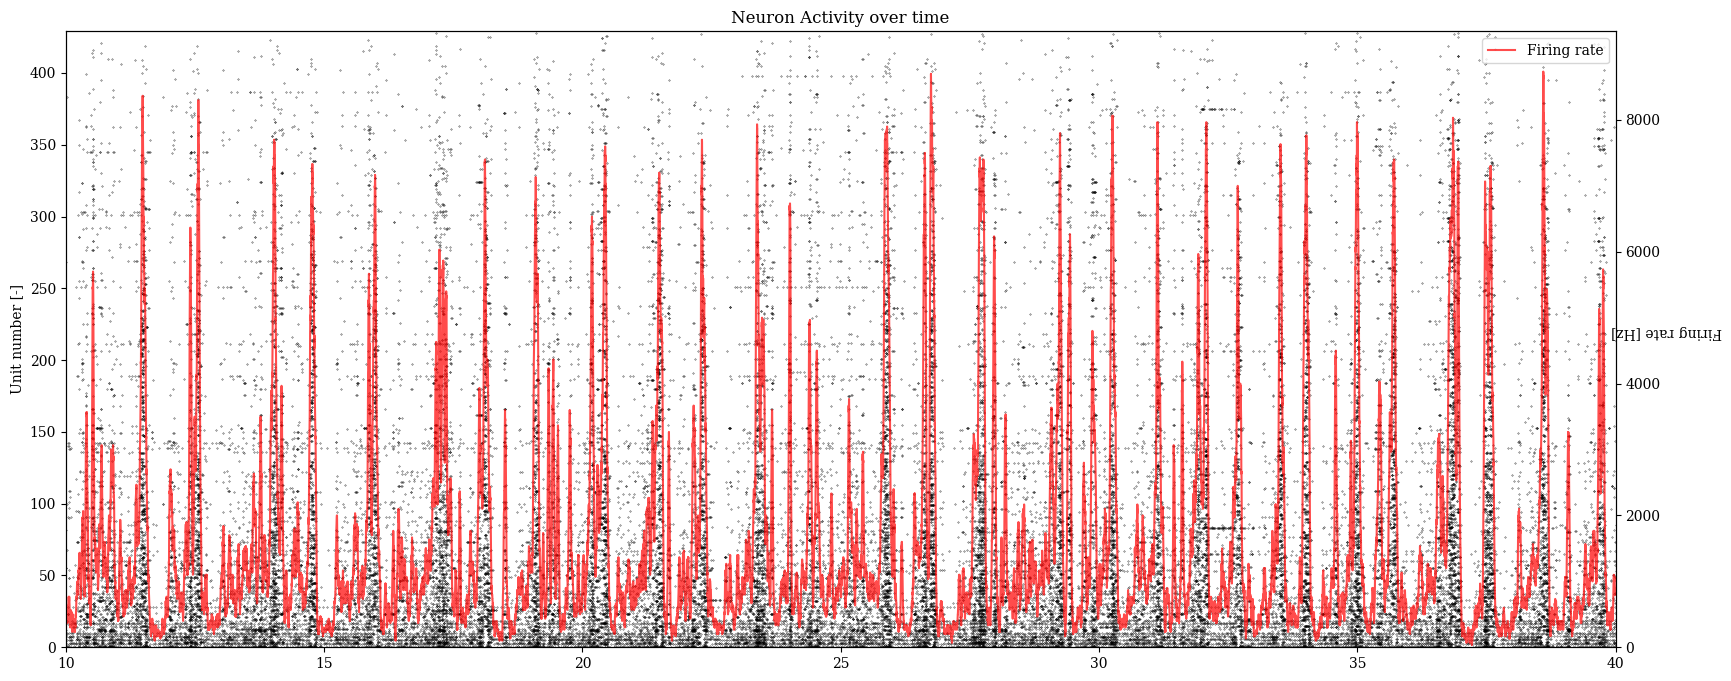

In [3]:
mea_data.raster_plot(sort=True, plot_avg=True, time_range=(10, 40))

### Firing rates

The red curve is the total firing rate (firings summed over all units, can be obtained with `mea_data.get_firings_total()`), smoothened with a running average of `window_size = 0.03` seconds. The number of data points is reduced by using `stride = window_size / 20`. This ensure that for each window, there are 20 data points, maintaining proper resolution. One can obtain this by using:

In [4]:
rate_total = mea_data.get_rate_total(window_size=0.03)

One can obtain the firing rates for each unit by smoothing the binary spike trains with a gaussian kernel with a certain width `sigma`. Using the `plot=True` function one can plot several spike trains to tune the `sigma`-parameter. After smoothing, data is saved with a certain `stride`, in order to reduce the number of data points. If the kernel size and stride are not defined, they will take default values as follows (in units of samples, so everything is multiplied by `sample_rate`):

`kernel_size = 6 * sigma * sample_rate`

`stride = sigma * sample_rate / 20`

This ensure that the kernel is virtually vanishes at the edges (gaussian vanishes at +/- 3 times the standard deviation), and that within the kernel 20 data points are taken for a proper resolution. 

There are two different methods for the smoothing:

- `method = 'Direct'`: directly smoothes the binary spike trains

- `method = 'ISI'`: scales each spike by the Inter-Spike-Interval before smoothing the binary spike trains. This makes the final firing rates less prone to isolates peaks, outside of burst, and thus less prone to false positives from the kilosort algorithm. One can see the difference below.

429it [01:54,  3.73it/s]


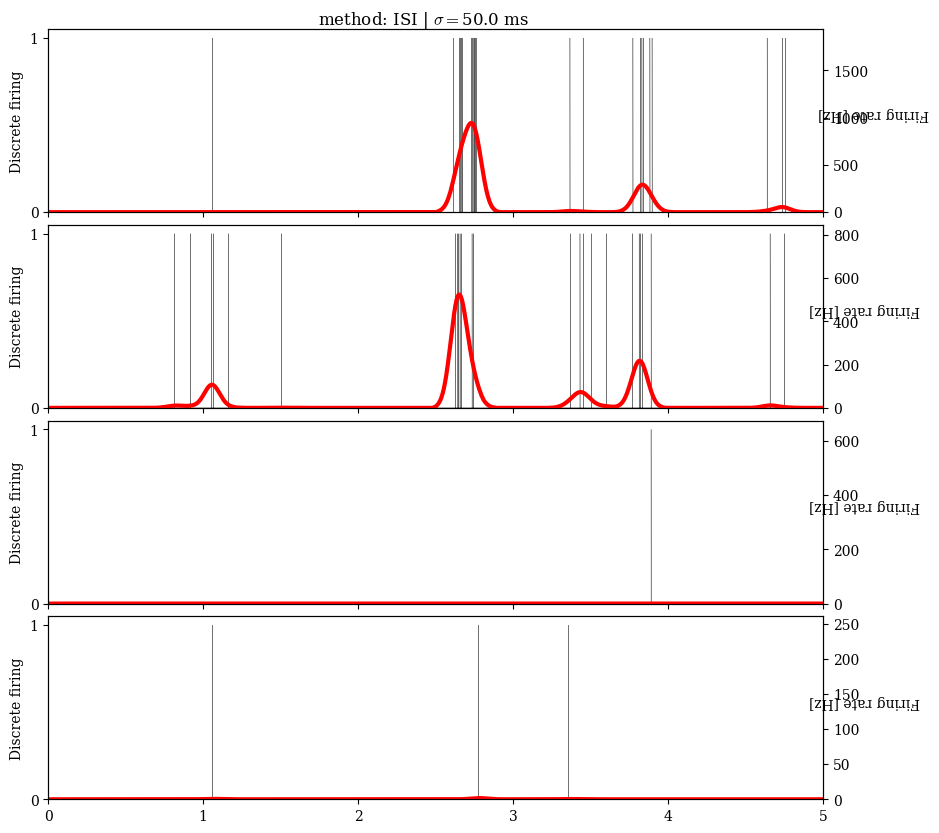

In [5]:
_ = mea_data.get_rates(method='ISI', sigma=0.05, plot=True)

429it [04:28,  1.60it/s]


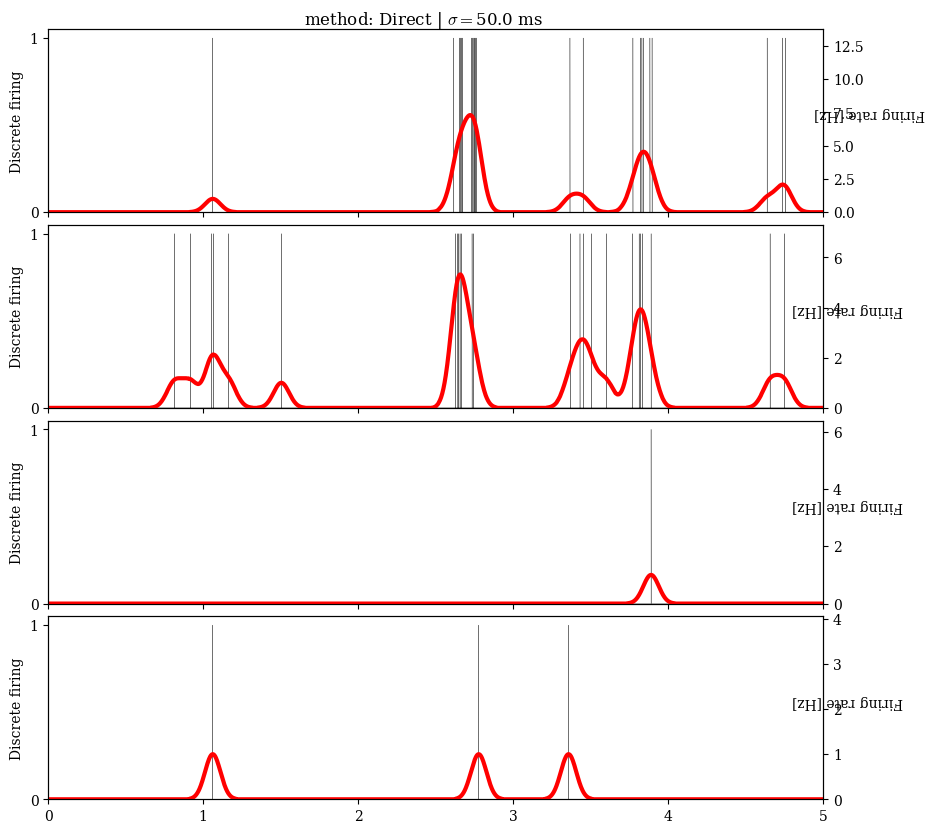

In [6]:
_ = mea_data.get_rates(method='Direct', sigma=0.05, plot=True)

### Spike Time Tiling Coefficient (STTC)

To quantify correlations between different units, the Spike Train Tiling Coefficient (STTC) is used (Cutts & Eglen, 2014). The STTC of spike train $i$ and $j$ is defined as

\begin{equation}
    STTC_{ij}(\Delta t) = \frac{1}{2}\left(\frac{P_{ij}-T_i}{1-P_{ij}T_i} + \frac{P_{ji}-T_j}{1-P_{ji}T_j}\right)
\end{equation}

where

- $P_{ij}(\Delta t)$: the fraction of spike in spike train $i$ that fall within a window $\Delta t$ around the spikes in spike train $j$. Overlapping window do NOT count double. 

- $T_{i}(\Delta t)$: the fraction of the total duration of spike train $i$ that is covered by windows of size $\Delta t$ around the spike in spike train $i$. 

In case of traditional implementation of this metric, one enters the desired value for $\Delta t$ in the parameter `dt_max`. However, this module allows for an adapated version of the STTC where the window around each spike begins at $\Delta t_{min}$ and ends at $\Delta t_{max}$. This way one can possibly gain insights in the exact time scale of correlation and how they might relate to the physical position in the culture. By simply setting $\Delta t_{min} = 0$, one retrieves the original definitation of the STTC as given by Cutts & Eglen. 

With the `sort` argument the STTC is plotted with all units sorted based on the average value of the STTC with all of the units.

There are two ways to make the tiling (creating the windows from $\Delta t_{min}$ to $\Delta t_{max}$ around each spike): 

- `tiling_method = 'direct'`: computes tiling directly by looping over all spikes
- `tiling_method = 'fft'`: uses a convolution in the fourier domain. 

In almost all cases, the `'direct'`-method is faster, so there is no need to change this. 

If `overwrite = False`, the computed STTC will be appended to a list of previous STTC-result, which can be accesses with `mea_data.sttc`. The corresponding values for $(\Delta t_{min}, \Delta t_{max})$ are stored as tuples in a list with the same size, which can be accessed with `mea_data.sttc_dt`. This way one can store multiple correlation matrices for different values for $\Delta t_{min}$, $\Delta t_{max}$. 

Make tilings...


429it [00:01, 244.84it/s]


Calculating STTC...
Total number of iterations: 91806


100%|██████████| 429/429 [09:10<00:00,  1.28s/it]


Plotting...


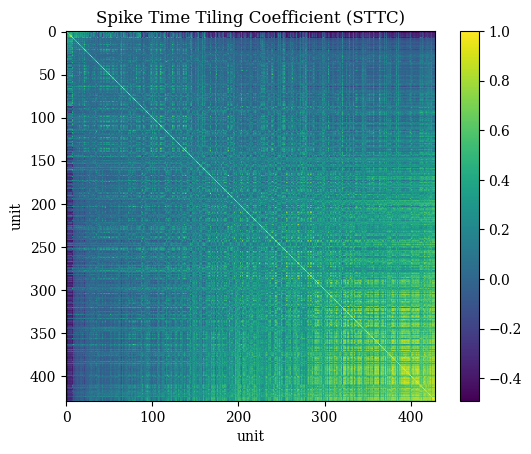

In [7]:
sttc = mea_data.compute_sttc(dt_max=0.05, dt_min=0, plot=True, sort=True, overwrite=True)

One way of defining a global property based on the pairwise correlations is to compare the distribution of STTC with a Poissonian simulation. This random simulation uses the same number of units, with each unit having the same firing rate averaged over the whole measurement time. However, the spike times are random.This will, by virtue of the central limit theorem, result in a Gaussian distribution of the STTC of the simulated data. One can compare the two distribution roughly in three different ways:

- `method = 'pdf'`: Take the area of the difference between the two distributions, quantifying the size of the tail of the STTC distribution of the data.
- `method = 'Cramer-von Mises'`: uses a metric based on the Cramér-von Mises critorion to quantify the difference between the two distributions. Let $F(x)$ be the cumulative distribution of the STTC of the data, and $G(x)$ be the cumulative distribution of the Poissonian data. The Cramér-von Mises metric $\omega$ for the difference between the two distributions is given by: $\omega^2 = \int_{-\infty}^\infty \left[F(x)-G(x)\right]^2 dx$
- `method = 'Wasserstein'`: uses the Wsserstein distance, also known as the Kantorovich–Rubinstein metric to quantify the difference between the two distributions. Using the same definitions as above, the Wasserstein distance $W$ is simply the area between the cumulative distributions: $W = \int_{-\infty}^\infty \left|F(x)-G(x)\right| dx$

Using either `method='Cramer-von Mises_data'` or `method='Cramer-von Mises_fit'` (similarly `method='Wasserstein_data'` or `method='Wasserstein_fit'`), one uses the binned simulated data or a Gaussian fit to the simulated data for $G(x)$. Using `'_fit'` is recommended as it is more accurate, but the difference is neglegible. 

If `method='all'`, all 5 metrics will be calculated and returned as a list. 

Other parameters that can be set are the `dt_max` and `dt_min` for calculating the STTC on the simulated data. It is important that these are set to the same values as one previously calculated the STTC on the data: the code will check whether the STTC on the data is already calculated to reduce computation time. If the STTC is not computed yet, it will compute it first. The number of bins for the data is set to `N_bins=120` by default. With the argument `plot_sim_hist=False`, one can remove the binned simulated data, which results in a more clear and readible plot. 

In case `mea_data.sttc` yields multiple STTC-matrices, the last element of this list is used to compare to the simulated data. 

Compute STTC on random simulation with dt = 0.05...
Make tilings...


429it [00:01, 235.26it/s]


Calculating STTC...
Total number of iterations: 91806


100%|██████████| 429/429 [09:04<00:00,  1.27s/it]


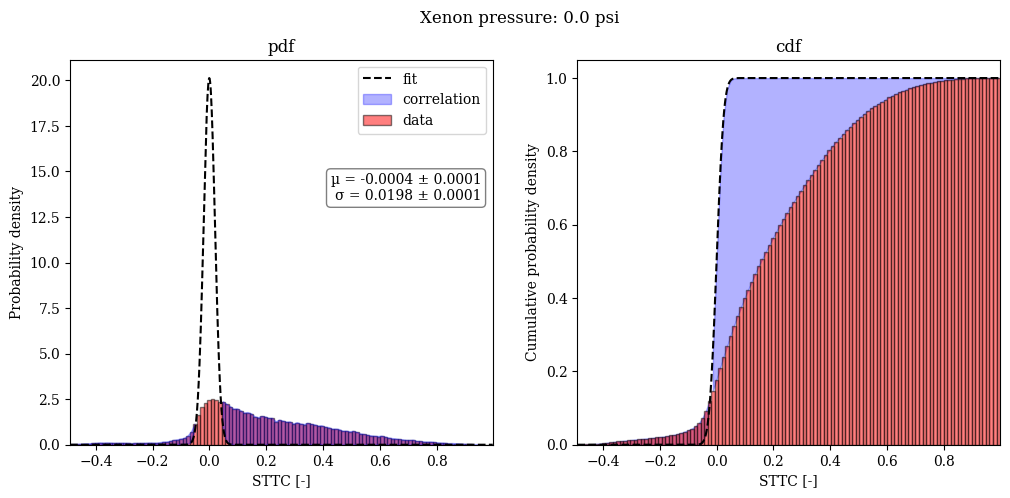

In [8]:
wasserstein_metric = mea_data.compare_STTC_to_random(dt_max=0.05, dt_min=0, method='Wasserstein_fit', plot_sim_hist=False)

### STTC with clustering

Based on the physical positions of the units on the MEA-chip, one can cluster the units using a K-Means clustering algorithm. Using the plotting tool, the number of cluster can be tuned to give accurate results

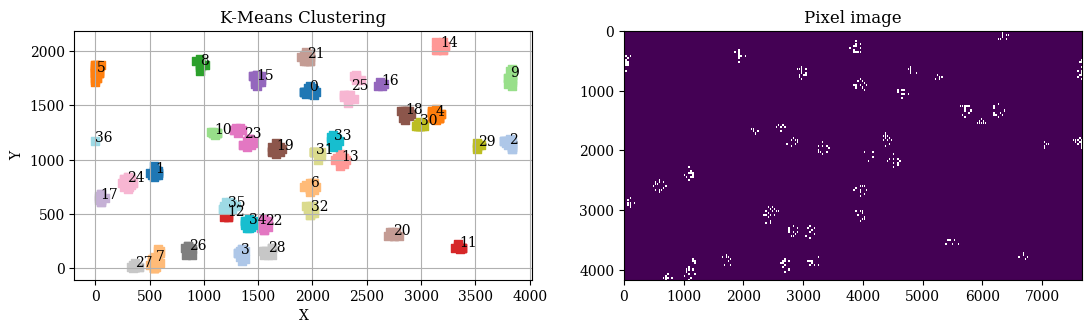

In [9]:
labels, centers = mea_data.get_clusters(n_clusters=37)

To see whether correlation within clusters, or between certain cluster, is higher than in general, we can plot the STTC clustered. The plot on the left shows the averaged for STTC within each pair of cluster. 

c:\Users\bow-lab\Documents\Code\spike_train_analysis\MEAData.py:582: RuntimeWarning: Mean of empty slice
  sttc_cluster = np.nanmean(sttc_result_ordered[labels_ordered == i][:,labels_ordered == j])


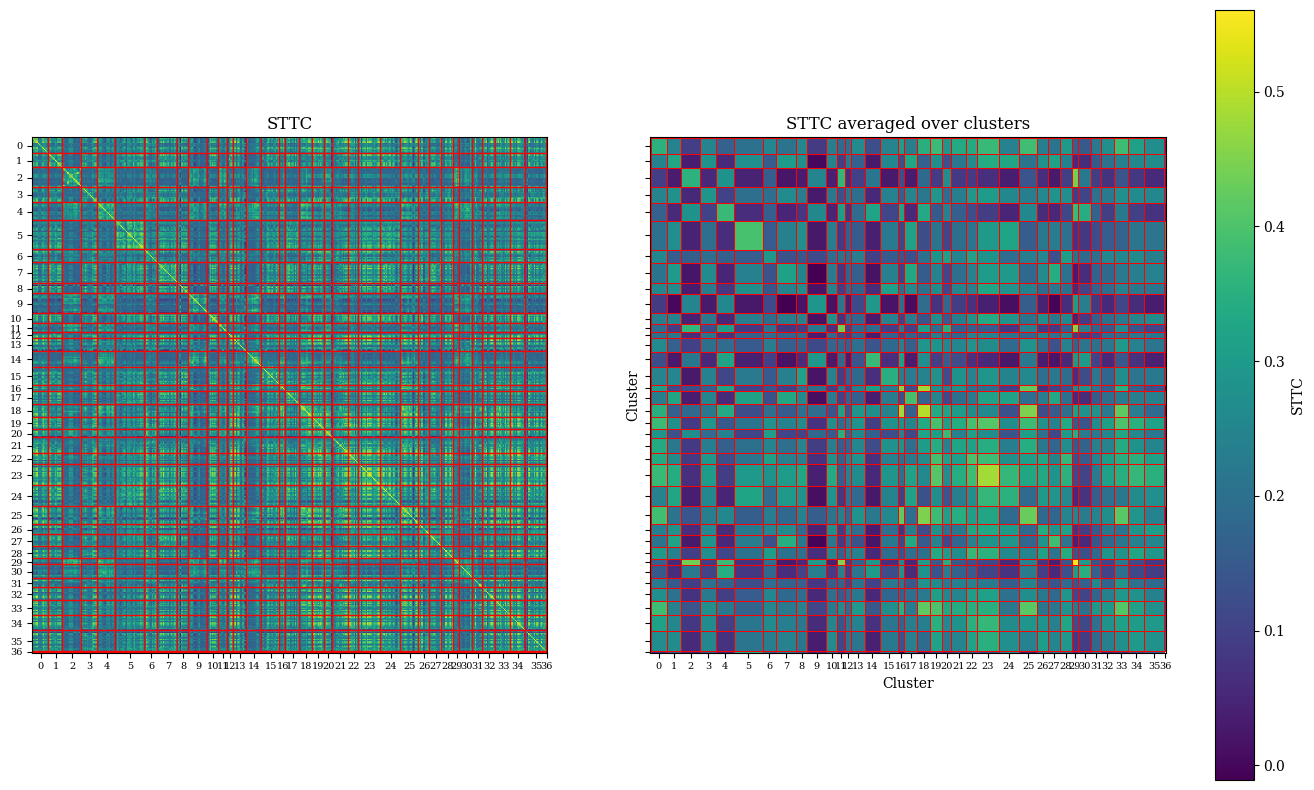

In [14]:
sttc_clustered = mea_data.get_STTC_clustered()

### Spike Contrast

The Spike Contrast (Ciba et. al, 2018) is an interesting metric to quantify the amount of contrast in the spike train. This is computed as follows: Given $N$ spike trains, the data is grouped in bins $k = 0, 1, 2, 3,...$ of size $\Delta t$. One first computes the contrast, defined as 

\begin{equation}
\mathrm{contrast}(\Delta t) = \frac{\sum_k \left|\theta_k  -\theta_{k-1}\right|}{2\sum_k\theta_k}
\end{equation}

where $\theta_k$ is the number of spikes in each bin. The denominator is a normalization term. Next, one calculates the number of active units (at least one firing) within in each bin $n_k$, and normalize this giving $\mathrm{activeST}(\Delta t)$

\begin{equation}
\mathrm{activeST}(\Delta t) = \frac{1}{N-1} \left(\frac{\sum_k n_k \theta_k}{\sum_k \theta_k} - 1\right)
\end{equation}

The final spike contrast $SC(\Delta t)$ is then given by

\begin{equation}
SC(\Delta t) = \mathrm{contrast}(\Delta t)\times \mathrm{activeST}(\Delta t) = \frac{1}{N-1} \frac{\sum_k |\theta_k - \theta_{k-1}|}{2\sum_k\theta_k} \left(\frac{\sum_k n_k \theta_k}{\sum_k \theta_k} - 1\right)
\end{equation}

For an explanation and derivation of the normalizations, please refer to Ciba et. al (2018). 

The final spiketrain metric is defined as the maximum of $SC(\Delta t)$ with respect to $\Delta t$. This maximum is determined within a range for $\Delta t$ defined with `(dt_min`, `dt_max)`. The number of points in between these two values is determined by `N_points`, default is 100. Usually, the bins overlap by half the binsize. This is done by setting the `stride_bin_ratio=2`. However, one can also have no overlap (`stride_bin_ratio=1`), 2/3 overlap (`stride_bin_ratio=3`), etc...


100%|██████████| 100/100 [05:28<00:00,  3.28s/it]


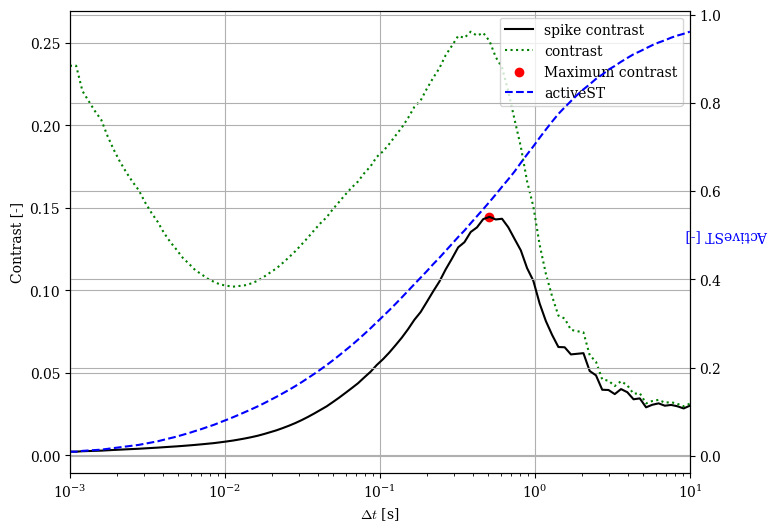

(0.1444829427156186, 0.5094138014816381)

In [11]:
mea_data.spike_contrast(dt_min=0.001, dt_max=10, N_points=100, stride_bin_ratio=2, plot=True)

Using the function `mea_data.run_all()`, one can run all the analysis methods described above. This will run all function with their default values, which might not be most accurate. It is therefore recommended to run all function separately. The method `mea_data.convert_results_to_dict()` return a dictionary with all results that are stored in the `MEAData` object. If some analysis metric are not computed yet, it will just save a `None` value. `mea_data.convert_results_to_dict()` takes one argument called `mode`, which can be set to either `mode='condensed'` and `mode='complete'`. If `mode='condensed'`, only the most crucial result are saved in case storage space is an issue, in contrast to `mode='complete'` which saves all data, even some redundant data. Please refer to the source code to see what exactly is saved in either these modes. 

Using `mea_data.save_data()` one can save this dictionary to a `.npz`-file. This method takes the file path and a boolean `run_all` as arguments. If `run_all` is true, it will first run `mea_data.run_all()`

In [6]:
saving_path = 'tutorial.pkl'

mea_data.save_data(path=saving_path, run_all=False, mode='minimal')

Finally create a `MEAData` object from one of these exported `.npz`-files. Just create an instance of `MEAData` and set the filetype argument to `file_type = 'processed'`. 

In [13]:
mea_data_processed = MEAData('tutorial.pkl', file_type='processed', pressure=0.0, overview=True)

mode               ()                 <class 'str'>
pressure           ()                 <class 'float'>
file_ID            ()                 <class 'str'>
N_units            ()                 <class 'int'>
N_samples          ()                 <class 'int'>
T_total            ()                 <class 'float'>
sample_rate        ()                 <class 'int'>
locs               (429, 2)           <class 'numpy.ndarray'>
trains             inhomogeneous      <class 'list'>
trains_binary      (429, 6000593)     <class 'numpy.ndarray'>
firings_total      (6000593,)         <class 'numpy.ndarray'>
rate_total         (200020,)          <class 'numpy.ndarray'>
time_rate_total    (200020,)          <class 'numpy.ndarray'>
rates              (429, 120012)      <class 'numpy.ndarray'>
time_rates         (429,)             <class 'numpy.ndarray'>
rates_avg          (429,)             <class 'numpy.ndarray'>
sttc               (429, 429)         <class 'numpy.ndarray'>
sttc_dt            (2